In [1]:
1+1

2

In [2]:
import numpy as np
import pylab as plt

from pynx.utils.array import rebin as pynx_rebin

import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/id01-core/id01lib/io/')
from h5utils import *

sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
from PreProcessing import *
from Plot_utilities import *
from Global_utilities import *

plt.rcParams['image.cmap'] = 'plasma'

In [3]:
# filename = '/data/id01/inhouse/bellec/InHouse/28_96_2022_Zlotnikov/experimental_data/id01/EBsample4/EBsample4_0029/EBsample4_0029.h5'
filename = '/data/id01/inhouse/bellec/software/sharedipynb/CEA_post_doc_experiment/Zlotnikov_inhouse_01_09_2023/experimental_data/day2afternoon/day2afternoon_0024/day2afternoon_0024.h5'
scanList = get_scans_title_str_hdf5(filename, '', verbose=True)

Available  scans in hdf5 file:
1 ... b'ascan ome 37.5 39.5 30 0.5'
2 ... b'ascan smax 3058 3078 20 0.5'
3 ... b'ascan ome 35.5 41.5 200 1'
4 ... b'ascan smax 3058 3078 20 0.5'
5 ... b'ascan ome 35.5 41.5 200 1'


In [4]:
scan_no = 3 # I'll show how it works for this scan
scan = openScan(filename, scan_no, verbose=True)

Scan no: 3.1
detector : mpx1x4
detector shape : (516, 516)
motor : ome


In [5]:
data = scan.getImages()
det_sum = np.sum(data, axis=0)

data.shape (201, 516, 516)


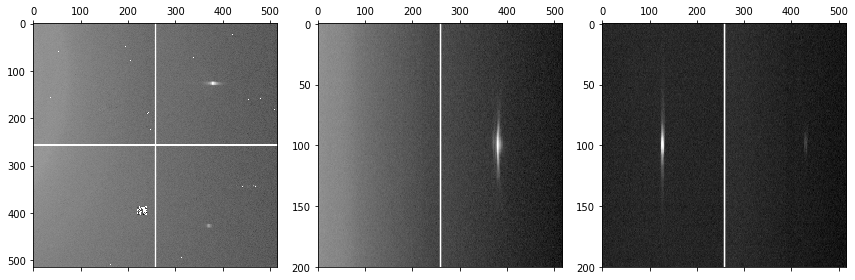

In [6]:
plot_3D_projections(data)

# Create a mask

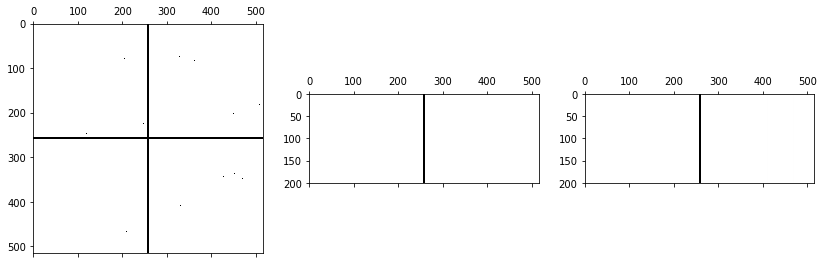

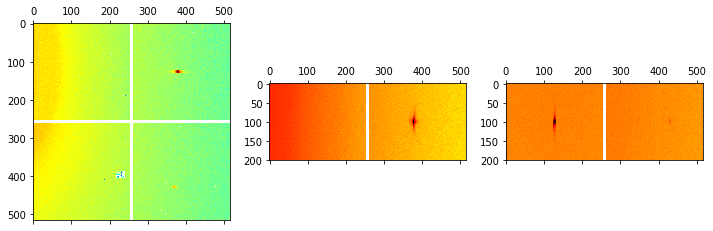

In [7]:
mask = load_mask(scan, data=data, plot=True)

# Select a ROI

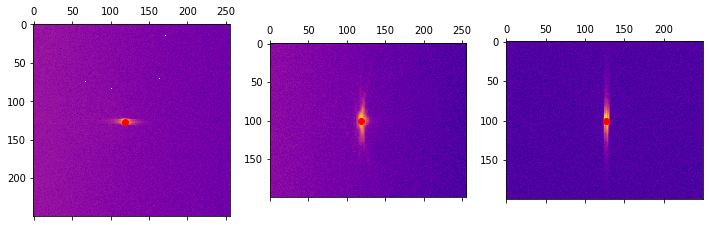

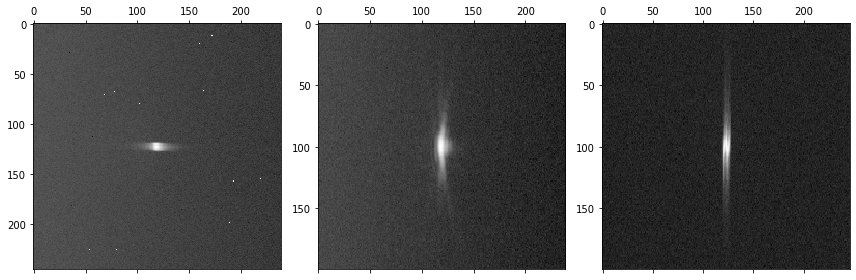

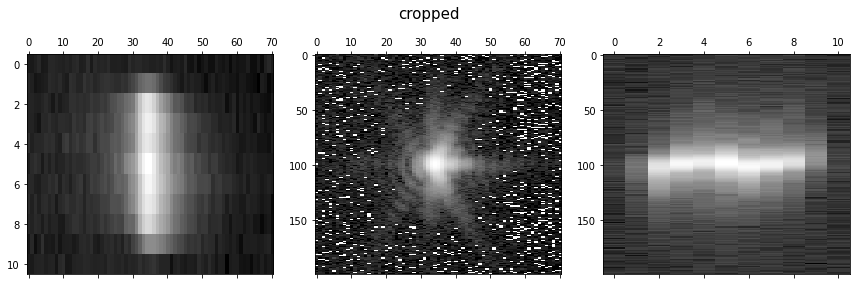

In [8]:
roi_init = [0,-1,0,250,260,516]

final_size_array = [ 441, 11, 70]
roi = automatic_roi_selection(data,
                              roi_init=roi_init,
                              crop_with_final_size=True, final_size_array=final_size_array,
                              plot=True)

In [9]:
# Apply the ROI once you think it's fine (run this cell only once ! )

data = data[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
mask = mask[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]

# Create q array (for future orthogonalization)

In [10]:
remove_rotation = True

# Force the detector calibration if needed
# det_calib = {'distance': 1.2960721362406218,
#  'beam_center_x': 67.39016449348968,
#  'beam_center_y': 34.92571482564213,
#  'x_pixel_size': 5.5e-05,
#  'y_pixel_size': 5.5e-05}

# Else, leave the detector calibration as it is in the h5 file
det_calib = None

if remove_rotation:
    # Remove rotation to avoid big gaps after orthogonalization
    phi = scan.getMotorPosition('ome')
    phi = phi-np.nanmean(phi)

qx,qy,qz = create_Q_array(scan,
                          roi = roi,
                          det_calib=det_calib,
                          chi=0,
                          phi = phi,
                          verbose=True)

phi : 0.0
eta : 0.0
chi : 0
delta : -0.04999999999999982
nu : -0.8875055555555555

energy (eV) : 8999.48867606242
detector_distance :1.396439726632378 m
beam_center_x :91.93333458632485 
beam_center_y :128.96883810096605 
detector pixel size x : 5.5e-05m
detector pixel size y : 5.5e-05m


# Flatfield

In [11]:
correct_flatfield = False

In [12]:
if correct_flatfield:

    flatfield_file = '/data/id01/inhouse/data_analysis/spatcorr-files/mpx22/ff_20200825_20kev_gaas/ff.h5'
    data = correct_flatfield(data, roi,
                          flatfield_file,
                          plot=True)

# Rebin data

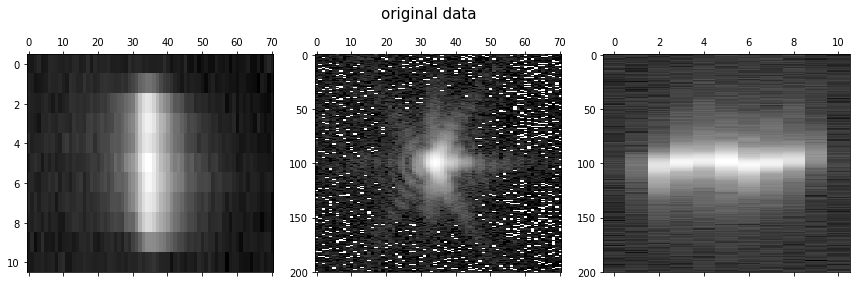

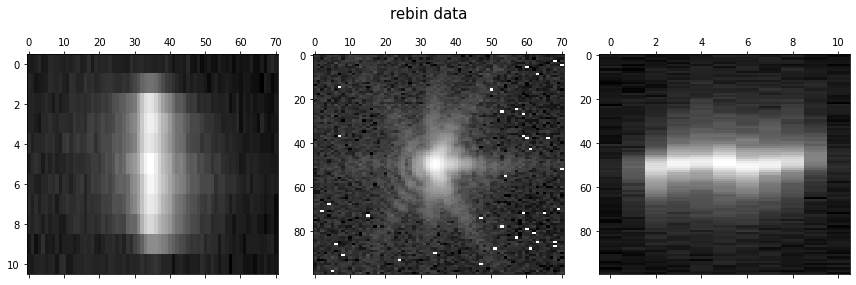

In [13]:
rebin = True
rebinning = (2,1,1)

if rebin :
    data_rebin = pynx_rebin(data, rebinning)
    plot_3D_projections(data, fig_title='original data')
    plot_3D_projections(data_rebin, fig_title='rebin data')

In [14]:
if rebin :
    data = data_rebin
    qx = pynx_rebin(qx, rebinning, scale='average')
    qy = pynx_rebin(qy, rebinning, scale='average')
    qz = pynx_rebin(qz, rebinning, scale='average')

    mask = pynx_rebin(mask, rebinning, scale='average')
    mask[mask!=0] = 1

# Remove linear background (optional)

In [15]:
remove_linear_background = False

if remove_linear_background:
    background = filter_background_zlotnikov(data, 
                                    nb_points_rocking=5,
                                    nb_points_start_end=7,
                                   const_relative_shift = .97,
                                    plot=True)

In [16]:
factor = 1.05

if remove_linear_background:
    plot_3D_projections(data)
    data_clean = data - factor * background[None] # Remove the background directly
    data_clean[data_clean<0] = 0
    plot_3D_projections(data_clean)

In [17]:
if remove_linear_background:
    data = data_clean

# Calculate the center of mass

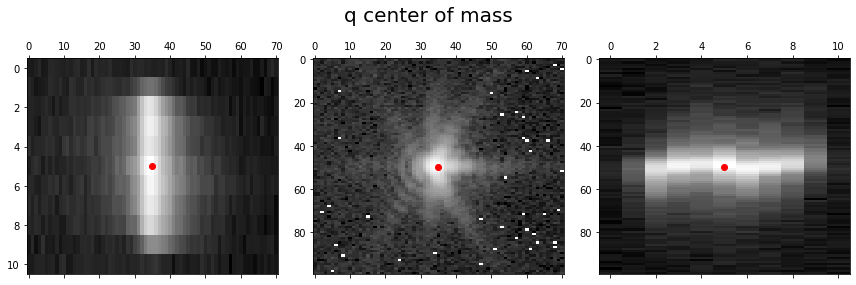

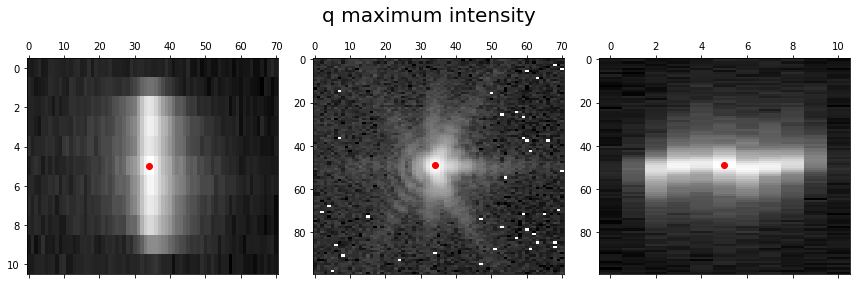

In [18]:
qcen = calculate_Q_center_of_mass(data, 
                             qx,qy,qz,
                             remove_min=True, plot=True)

qmax = calculate_qmax(data, 
                   qx,qy,qz,
                   plot=True)

# Make the orthogonalization

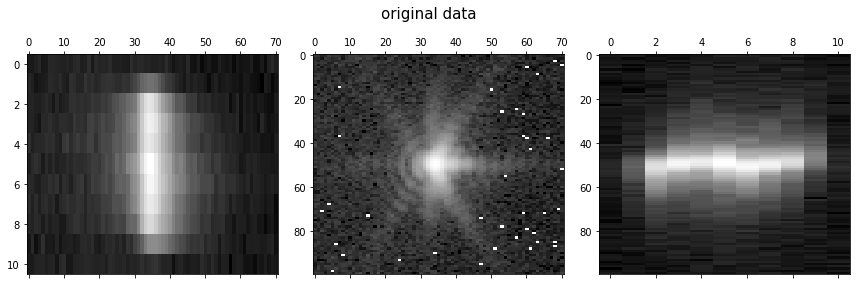

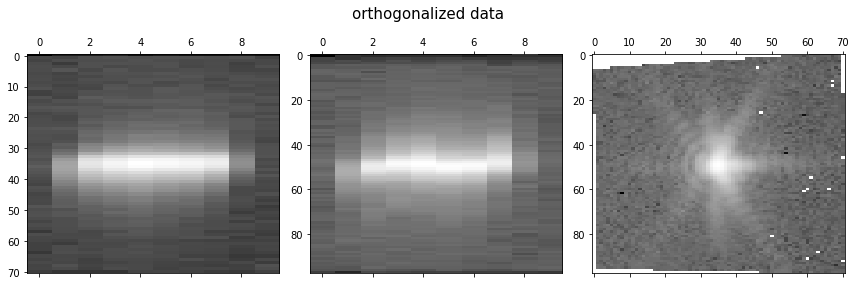

In [19]:
orthogonalization = True

if orthogonalization:
    data, mask, qx, qy, qz = Q_space_transformation(data, qx, qy, qz, mask=mask, plot=True)

## Crop data again after orthogonalization

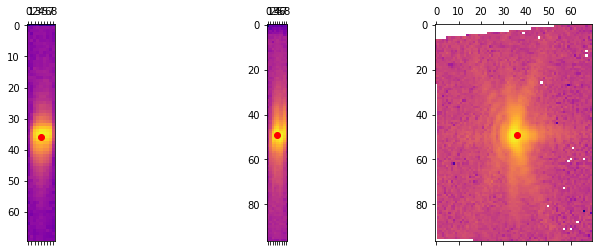

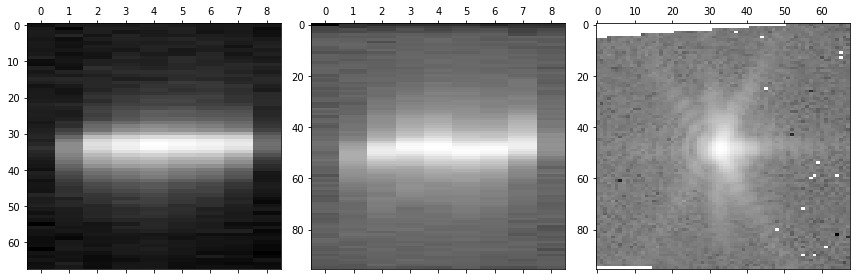

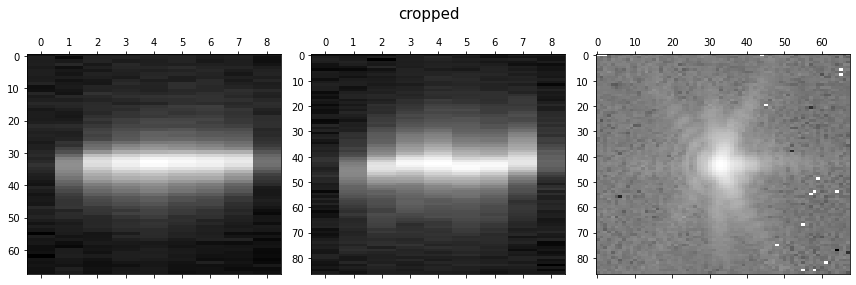

In [22]:
roi_init = [0,-1,0,-1,0,-1]

# crop_array = [ 20, 30, 12] 
# crop_array = [ 40, 16, 0] 
crop_array = [ 10, 0, 0] 

roi = automatic_roi_selection(data,
                              roi_init=roi_init,
                              crop=True, crop_array=crop_array,
                              plot=True)

In [23]:
data = data[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
qx = qx[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
qy = qy[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
qz = qz[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
mask = mask[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]

# Rebin after orthogonalization

In [24]:
rebin_final = False
rebinning_final = (1,2,1)

if rebin_final and orthogonalization:
    data_rebin = pynx_rebin(data, rebinning_final)
    plot_3D_projections(data, fig_title='original data')
    plot_3D_projections(data_rebin, fig_title='rebin data')

In [25]:
if rebin_final and orthogonalization:
    data = data_rebin
    qx = pynx_rebin(qx, rebinning_final, scale='average')
    qy = pynx_rebin(qy, rebinning_final, scale='average')
    qz = pynx_rebin(qz, rebinning_final, scale='average')

    mask = pynx_rebin(mask, rebinning_final, scale='average')
    mask[mask!=0] = 1

# Only keep the 2D data

In [26]:
data3d = np.copy(data)

In [27]:
if orthogonalization:

    data = np.nanmean(data3d, axis=2)
    data[data<0] = 0 # Remove all negative data from background subtraction

    qx = np.nanmean(qx, axis=2)
    qy = np.nanmean(qy, axis=2)
    qz = np.nanmean(qz, axis=2)
    
else:
    data = np.nanmean(data3d, axis=1)

    qx = np.nanmean(qx, axis=1)
    qy = np.nanmean(qy, axis=1)
    qz = np.nanmean(qz, axis=1)

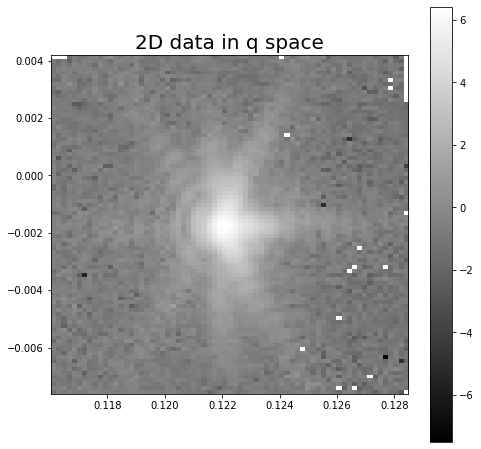

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(np.log(data), extent=[qy.min(),qy.max(),qx.min(),qx.max()], cmap='gray')
plt.title('2D data in q space', fontsize=20)
plt.colorbar()

# Make sure all dimensions are even (not great but it will avoid problems)

In [29]:
data, qx,qy,qz, mask = force_even_dimension(data, qx,qy,qz, mask, verbose=True)

shape changed :

qx (87, 69) to (86, 68)
qy (87, 69) to (86, 68)
qz (87, 69) to (86, 68)
data (87, 69) to (86, 68)
mask (87, 69, 9) to (86, 68, 9)


# Save the pre-processed data

In [30]:
savename_add_string = ''

if rebin:
    savename_add_string += '_rebin'
    
if remove_linear_background:
    savename_add_string += '_linbackcorr'
    
if remove_rotation:
    savename_add_string += '_rotremoved'
    
if rebin_final:
    savename_add_string += '_rebinfinal'    

if not orthogonalization:
    savename_add_string += '_labspace' 
    
print('savename_add_string : ', savename_add_string)

savename_add_string :  _rebin_rotremoved


In [31]:
additional_dict={'tobz': scan.getMotorPosition('tobz'),
                 'piz': scan.getMotorPosition('piz'),
                 'data3d' : data3d,
                 'phi_cen' : np.nanmean(scan.getMotorPosition('phi'))}

save_preprocessed_data(scan, data, qx, qy, qz,
                       orthogonalization=orthogonalization,
                       mask=mask,
                       qcen=qcen, qmax=qmax, 
                       additional_dict=additional_dict,
                      savename_add_string=savename_add_string)

preprocessed data saved in : preprocessed_data_day2afternoon/dataset_day2afternoon_0024_scan_3_ortho_rebin_rotremoved.npz
